# Waveforms

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sxs

## Loading waveforms

We can load a waveform much like the rest of our data:

In [2]:
sxs_bbh_1234 = sxs.load("SXS:BBH:1234")
w = sxs_bbh_1234.h

Note that we include an extra argument: `extrapolation_order`.  This is because in the old format, multiple extrapolations are stored within a single file, and the "select" process just returns the file itself.  If you don't pass this argument, a `dict` with all extrapolations is returned.  We'll come back to this below.

The most important attributes of any waveform object are

  * the time: `w.t`
  * the data: `w.data`

Here, the data is a complex array with first dimension representing the time and second dimension ranging over the modes.  We can plot the data:

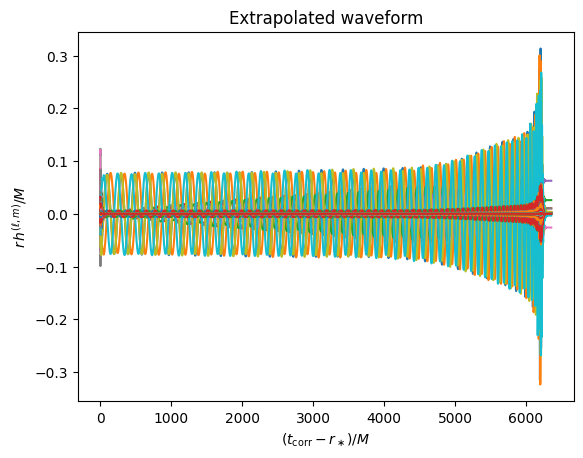

In [3]:
plt.plot(w.t, w.data.view(float))
plt.title(f"Extrapolated waveform")
plt.xlabel(r"$(t_{\mathrm{corr}} - r_\ast)/M$")
plt.ylabel(r"$r\, h^{(\ell,m)}/M$");

## Junk radiation and slicing waveforms

The horizontal axis represents the retarded time.  Note that this starts *before* $(t_{\mathrm{corr}} - r_\ast)/M = 0$; the data are extracted starting at $t=0$, but at radii $r>0$.  We include this data because it can be useful for understanding things like junk radiation, or why the ADM mass computed from the initial data is different from the Bondi mass more relevant during the inspiral.

We provide a ***VERY*** rough estimate for when the data has settled down, which can be used to chop off the initial burst of junk radiation.  It is given as `reference_time` in the metadata, so let's load the metadata for this system:

In [4]:
reference_time = sxs_bbh_1234.metadata.reference_time

Just visually, that looks like a reasonable time by which the worst wiggles have died down.  We can find the index of this time in the waveform data like this:

In [5]:
reference_index = w.index_closest_to(reference_time)

Then, we can slice `w` just like a standard numpy array to just take everything after that index:

In [6]:
w_sliced = w[reference_index:]

The result is a new waveform object, with the correctly sliced `time` and correctly sliced `data`.  (Note that we don't currently support "fancy indexing" that numpy arrays support; only basic slicing works.)

So we plot it again:

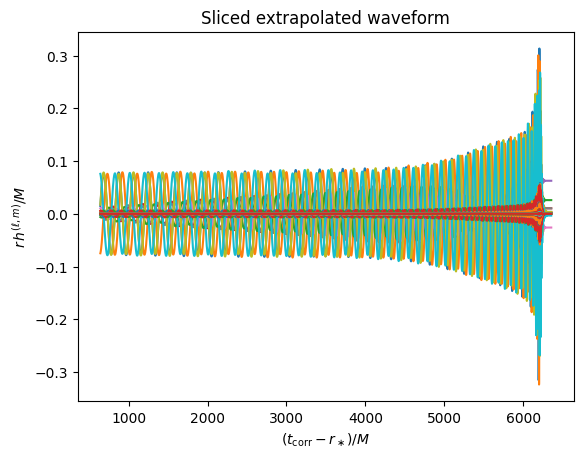

In [7]:
plt.plot(w_sliced.t, w_sliced.data.view(float))
plt.title(f"Sliced extrapolated waveform")
plt.xlabel(r"$(t_{\mathrm{corr}} - r_\ast)/M$")
plt.ylabel(r"$r\, h^{(\ell,m)}/M$");

Indeed, we see that the junk is gone.

## Waveform norm and more slicing

Especially with precessing systems, it's nice to use rotationally invariant quantities to understand the data.  The simplest one is just the $L^2$ norm:
\begin{align}
  \texttt{w.norm}
  &= \sqrt{\int_{S^2} |w|^2 dA} \\
  &= \sqrt{ \sum_{\ell, m} \left| w^{\ell,m} \right|^2 }
\end{align}
This is returned as a function of time.  We also have a convenient function for finding the time at which the norm reaches its maximum (which is a convenient proxy for merger):

In [8]:
w.max_norm_time()

6203.712416974952

We can plot the norm as a function of time, and a vertical line to show where it reaches that maximum value:

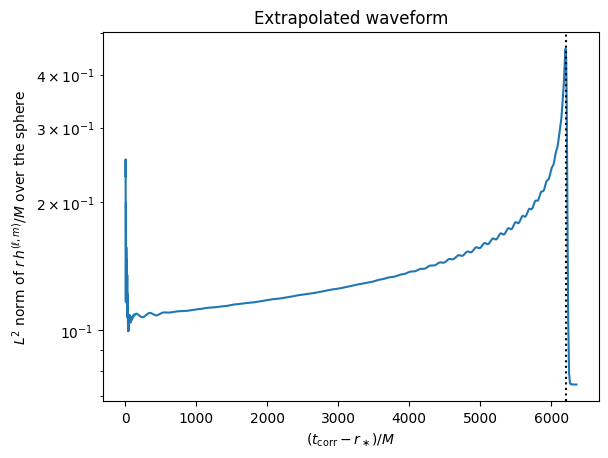

In [9]:
plt.semilogy(w.t, w.norm)
plt.axvline(w.max_norm_time(), c="black", ls="dotted")
plt.title(f"Extrapolated waveform")
plt.xlabel(r"$(t_{\mathrm{corr}} - r_\ast)/M$")
plt.ylabel(r"$L^2$ norm of $r\, h^{(\ell,m)}/M$ over the sphere");

Now, we might want to look at what the modes are doing during ringdown, so we'll slice off all the data from before `max_norm_time`.  But we also see that the ringdown doesn't last very long before numerical garbage creeps in, so let's slice off times more than $100M$ past the peak:

In [10]:
i1 = w.index_closest_to(w.max_norm_time())
i2 = w.index_closest_to(w.max_norm_time() + 100.0)
w_ringdown = w[i1:i2]

And this time, we'll just look at the absolute values of the mode weights, which is accessible through the `.abs` attribute:

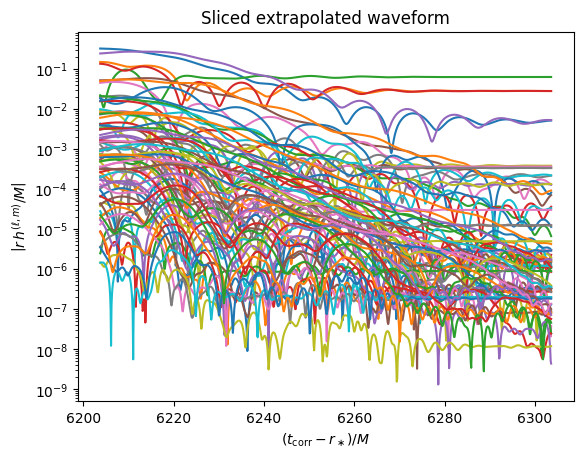

In [11]:
plt.semilogy(w_ringdown.t, w_ringdown.abs)

plt.title(f"Sliced extrapolated waveform")
plt.xlabel(r"$(t_{\mathrm{corr}} - r_\ast)/M$")
plt.ylabel(r"$\left| r\, h^{(\ell,m)}/M \right|$");

Note that some of these modes do not look entirely credible.  There
are certainly significant gauge effects here, and possibly problems
with numerical resolution.  In particular, many modes "ring down" to a
nonzero value, which is not what we normally expect, though these may
just be the correct results of BMS gauge effects.

## Slicing modes

Above, we saw how to slice times.  Essentially `waveform` is a 2-dimensional array, with time running along the first dimension, so that's how we sliced.  But as we move along the second dimension, we move through different modes.  Sometimes, we may not want to keep that mess of modes we see in the plot above, so we slice some of them off.

First, it's important to understand the order in which modes are stored.  We start with the smallest values of $\ell$ and $m=-\ell$, increment $m$ until we run out of valid values, then increment $\ell$ up to its maximum value.  So the order looks like this:

    [[2, -2], [2, -1], [2, 0], [2, 1], [2, 2], [3, -3], [3, -2], ..., [8, 7], [8, 8]]

The waveform needs to know the minimum and maximum values of $\ell$ stored in its data:

In [13]:
w.ell_min, w.ell_max

(2, 8)

You can also get the complete list of $(\ell, m)$ values was `w.LM`.

Now, we see that the first five modes comprise all modes with $\ell=2$.  As with a numpy array, we slice the second dimension just by slicing the first dimension, then putting a comma, and the slice for the second dimension.  To keep all times but only the first 5 modes, we can do this:

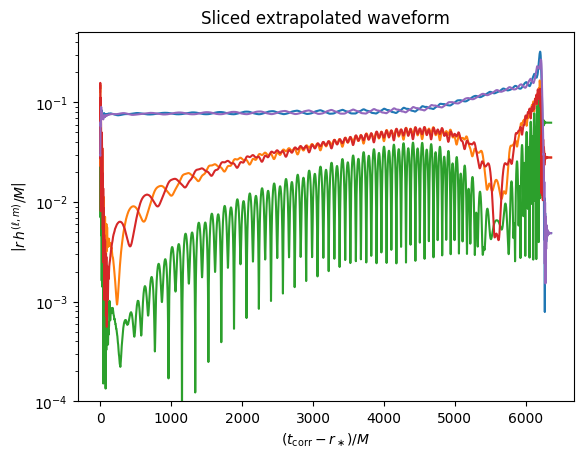

In [14]:
w_ell2 = w[:, :5]

plt.semilogy(w_ell2.t, w_ell2.abs)
plt.ylim(bottom=1e-4)
plt.title(f"Sliced extrapolated waveform")
plt.xlabel(r"$(t_{\mathrm{corr}} - r_\ast)/M$")
plt.ylabel(r"$\left| r\, h^{(\ell,m)}/M \right|$");

We can also find the index for a particular $(\ell, m)$ mode like this:

In [15]:
ell, m = 2, 2
w.index(ell, m)

4

(As always, note that element 4 is the fifth element because python's indexing is zero-based.)

We could also take just a single mode:

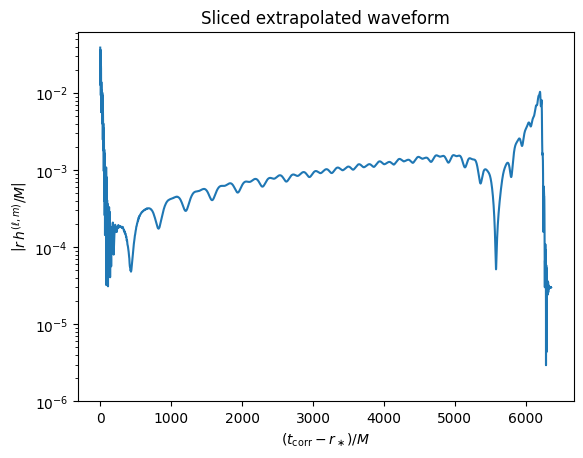

In [16]:
w_4_3 = w[:, w.index(4, 3)]

plt.semilogy(w_4_3.t, w_4_3.abs)
plt.ylim(bottom=1e-6)
plt.title(f"Sliced extrapolated waveform")
plt.xlabel(r"$(t_{\mathrm{corr}} - r_\ast)/M$")
plt.ylabel(r"$\left| r\, h^{(\ell,m)}/M \right|$");

Or we could take a range of modes not starting at $(2, -2)$:

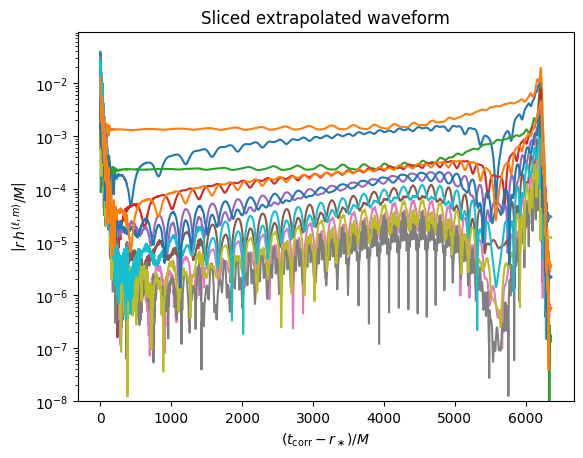

In [17]:
w_range = w[:, w.index(4, 3):w.index(5, 5)]

plt.semilogy(w_range.t, w_range.abs)
plt.ylim(bottom=1e-8)
plt.title(f"Sliced extrapolated waveform")
plt.xlabel(r"$(t_{\mathrm{corr}} - r_\ast)/M$")
plt.ylabel(r"$\left| r\, h^{(\ell,m)}/M \right|$");

## Other convenient features

We also have built-in methods to extract the amplitude and phase:

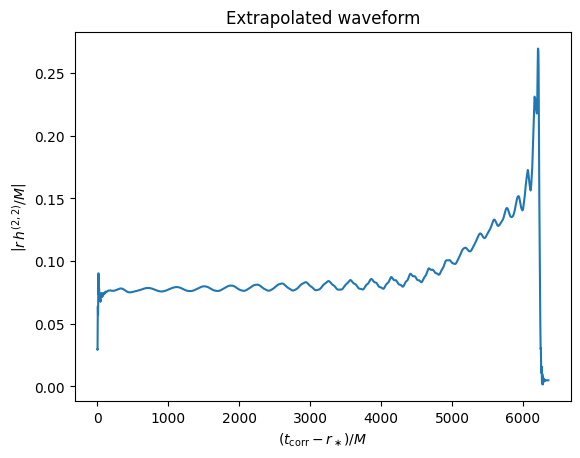

In [18]:
plt.plot(w.t, w[:, w.index(2, 2)].abs)

plt.title(f"Extrapolated waveform")
plt.xlabel(r"$(t_{\mathrm{corr}} - r_\ast)/M$")
plt.ylabel(r"$\left| r\, h^{(2,2)}/M \right|$");
#plt.ylim(bottom=1e-7);
# plt.legend([f"({ell}, {m})" for ell, m in w.LM]);

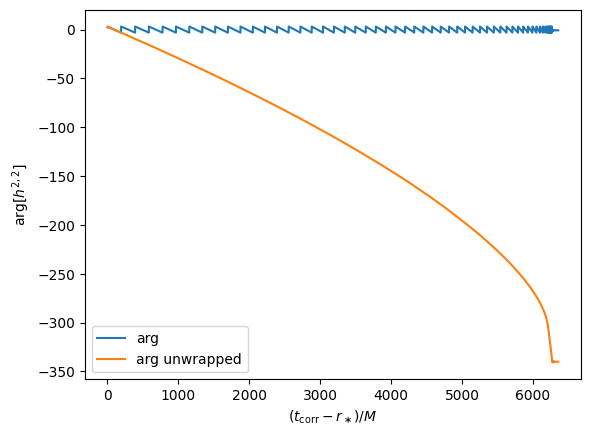

In [19]:
ell, m = 2, 2
plt.plot(w.t, w.arg[:, w.index(ell, m)], label='arg')
plt.plot(w.t, w.arg_unwrapped[:, w.index(ell, m)], label='arg unwrapped')
plt.xlabel(r"$(t_{\mathrm{corr}} - r_\ast)/M$")
plt.ylabel(rf"$\mathrm{{arg}} \left[ h^{{{ell}, {m}}} \right]$")
plt.legend();

Here, we see that there are two types of phase: the usual `arg`, and an "unwrapped" version that removes discontinuities.

## Extrapolation orders

Currently, the waveform data supplied by the SXS collaboration are
extrapolated to infinite radius by extracting on a series of radii
surrounding the binary, adjusting the time offset to account for the
tortoise-coordinate retarded time and for effects due to changing
radius of the extraction spheres, fitting the data at each retarded
time to a polynomial in $1/r$, and then extrapolating to $r=\infty$.

The polynomial orders are N=2, 3, or 4.  Additionally, one data set is
corrected as described above, but then the data from the outermost
extraction radius is simply output.  We can choose among these
different options by specifying the `extrapolation` argument when
loading the simulation:

In [20]:
h_N2 = sxs.load("SXS:BBH:1234", extrapolation="N2").h
h_N3 = sxs.load("SXS:BBH:1234", extrapolation="N3").h
h_N4 = sxs.load("SXS:BBH:1234", extrapolation="N4").h
h_Outer = sxs.load("SXS:BBH:1234", extrapolation="Outer").h

  0%|                                                                | 0/4181944 [00:00<?, ?it/s]

  0%|                                                                | 0/4391004 [00:00<?, ?it/s]

  0%|                                                                | 0/3924497 [00:00<?, ?it/s]

And here, we just plot the amplitudes of the $(2, 2)$ modes from the various extrapolations.  We have to zoom pretty far in to see any differences, suggesting that this particular simulation was extracted sufficiently far away that extrapolation doesn't have much work to do.

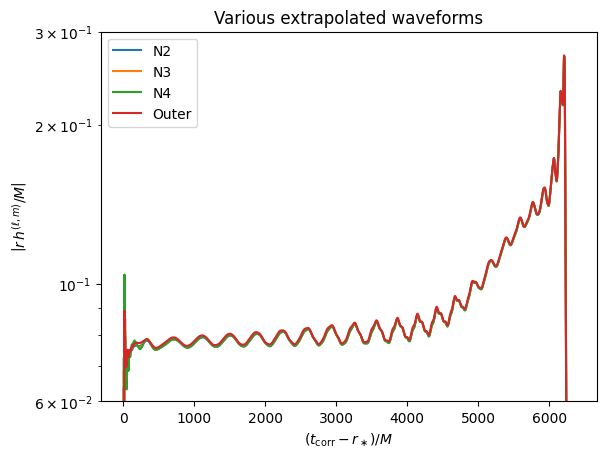

In [21]:
for w_i in [h_N2, h_N3, h_N4, h_Outer]:
    plt.semilogy(w_i.t, w_i.abs[:, w_i.index(2, 2)])
plt.ylim(0.06, 0.3);

plt.title(f"Various extrapolated waveforms")
plt.xlabel(r"$(t_{\mathrm{corr}} - r_\ast)/M$")
plt.ylabel(r"$\left| r\, h^{(\ell,m)}/M \right|$");
plt.legend(["N2", "N3", "N4", "Outer"], loc="upper left");

## Backwards compatibility

As with the `Horizons` objects, the recommended way to load data from a file used to be to open it with `h5py`, and then directly extract datasets.  The user might do something like this:

```python
with h5py.File("rhOverM_Asymptotic_GeometricUnits_CoM.h5", "r") as f:
    time = f["Extrapolated_N2.dir/Y_l2_m2.dat"][:, 0]
    h_22 = f["Extrapolated_N2.dir/Y_l2_m2.dat"][:, 1:]
```

With newer data, this code will break because the format of the files has changed.  However, we can use the waveform object to provide an interface that is as close as possible to the old interface so that code that works with the old files can continue to work with new files, with a minimal set of changes.

In particular, it is still possible to extract that data *from an individual extrapolation* like `waveform["Y_l2_m2.dat"]`.  Moreover, when you do not specify the extrapolation level, the object you get back will pass these strings through correctly, so you can do something like `w_dict["Extrapolated_N2.dir/Y_l2_m2.dat"]` to get the old-style data.  In fact, the code above could be replaced with something very similar:

```python
with sxs.loadcontext("rhOverM_Asymptotic_GeometricUnits_CoM.h5") as f:
    time = f["Extrapolated_N2.dir/Y_l2_m2.dat"][:, 0]
    h_22 = f["Extrapolated_N2.dir/Y_l2_m2.dat"][:, 1:]
```

For old-style NRAR-format waveform files, the results are identical.  But this latter version of the code will also work with newer formats.  Thus, only ***one function call*** would need to change to use newer files.  (And in fact, the `loadcontext` function is even a bit nicer because it can handle the downloading and caching for you, just like `sxs.load`.)

However, be aware that this may not an be efficient use of memory, and is almost certainly slower than the newer interfaces.  Wherever possible, you should update your code to use newer interfaces.  Failing to do so will leave you open to ridicule from your peers and loved ones.

## The effects of CoM correction

For non-precessing systems with small eccentricity, we naively expect the waveforms to be quite smoothly varying functions of time during the inspiral.  In particular, we do not expect the mode *amplitudes* to oscillate.  Nonetheless, there are plenty of examples of such systems in the SXS catalog where some modes *do* oscillate visibly.  The reason behind this is discussed extensively in [this paper](https://arxiv.org/abs/1904.04842).  Basically, there is an overall offset and drift of the origin of coordinates relative to the "center of mass" of the binary, which leads to power moving between modes — especially power from the dominant $(\ell, m) = (2, \pm 2)$ modes into lower-amplitude modes.

For example, SXS:BBH:0314 is a system with mass ratio 1.23, and moderate spins of 0.31 and -0.46 along the orbital axis, and no measurable component of spin in the orbital plane — hence no precession.  But if we look at the $(2, 1)$ mode amplitude, we see a very clear oscillation.  Here, we use an older interface to load the data, because the uncorrected data is no longer supplied in the newer format:

Found the following files to load from the SXS catalog:
    SXS:BBH:0314v5/Lev4/rhOverM_Asymptotic_GeometricUnits.h5


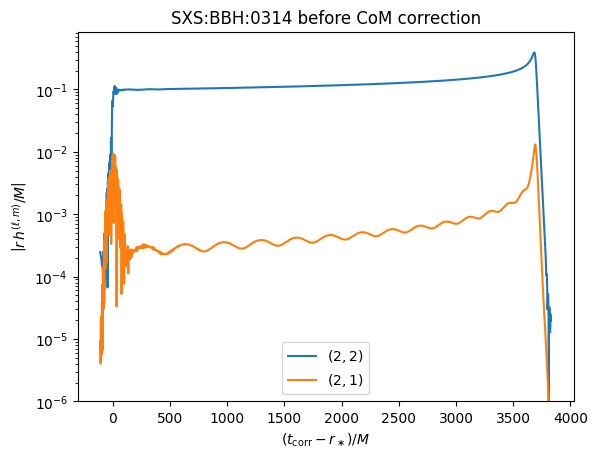

In [22]:
w0314 = sxs.load("SXS:BBH:0314/Lev/rhOverM_Asymptotic_GeometricUnits.h5", extrapolation_order=2)

plt.semilogy(w0314.t, np.abs(w0314.data[:, [w0314.index(2, 2), w0314.index(2, 1)]]))
plt.title("SXS:BBH:0314 before CoM correction")
plt.xlabel(r"$(t_{\mathrm{corr}} - r_\ast)/M$")
plt.ylabel(r"$\left| r\, h^{(\ell,m)}/M \right|$")
plt.ylim(bottom=1e-6)
plt.legend([r"$(2, 2)$", r"$(2, 1)$"]);

We can look at the same waveform *after* the origin of the coordinates has been corrected for the motion of the center of mass.  Here, we include the original data as a slightly transparent line, and the corrected data as the opaque line.  It is clear that the unexpected oscillations are gone from the corrected data (or at least *far* smaller).

Found the following files to load from the SXS catalog:
    SXS:BBH:0314v5/Lev4/rhOverM_Asymptotic_GeometricUnits_CoM.h5


  0%|                                                               | 0/76446956 [00:00<?, ?it/s]

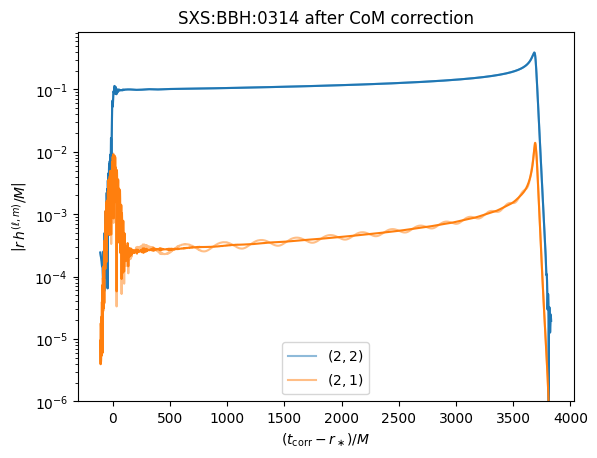

In [23]:
w0314_com = sxs.load("SXS:BBH:0314/Lev/rhOverM_Asymptotic_GeometricUnits_CoM.h5", extrapolation_order=2)

lines_original = plt.semilogy(w0314.t, np.abs(w0314.data[:, [w0314.index(2, 2), w0314.index(2, 1)]]), alpha=0.5)
lines_corrected = plt.semilogy(w0314_com.t, np.abs(w0314_com.data[:, [w0314_com.index(2, 2), w0314_com.index(2, 1)]]))
for l1, l2 in zip(lines_original, lines_corrected):
    l2.set_color(l1.get_color())
plt.title("SXS:BBH:0314 after CoM correction")
plt.xlabel(r"$(t_{\mathrm{corr}} - r_\ast)/M$")
plt.ylabel(r"$\left| r\, h^{(\ell,m)}/M \right|$")
plt.ylim(bottom=1e-6)
plt.legend([r"$(2, 2)$", r"$(2, 1)$"]);

## Evaluating the waveform in particular directions

The objects we've been dealing with above have all encapsulated the gravitational waves emitted by a binary in all directions, in the form of mode weights of a spin-weighted spherical harmonic decomposition.  But to model what a detector sees, we need to evaluate the function in a particular direction.

The function that does this is the `evaluate` method.  We assume that the binary is (at least approximately) orbiting the origin of the coordinates, and the detector is very far away in the direction $(\theta, \phi)$.  Then the signal measured by a detector with arms along $(\hat{\theta}, \hat{\phi})$ would be the real part of the following, while the signal measured by a detector rotated by 45° would be the imaginary part:

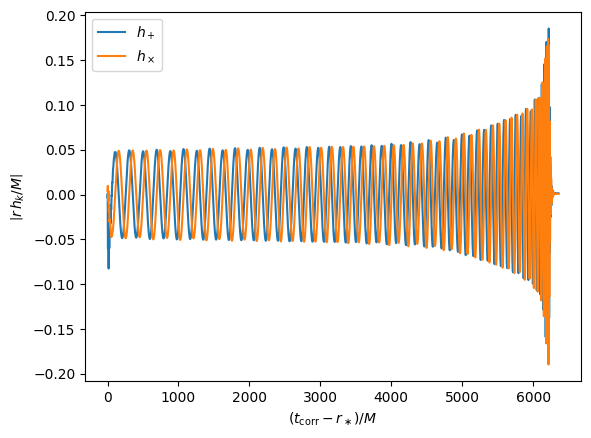

In [24]:
θ, ϕ = 0.1, 0.2
s = w.evaluate(θ, ϕ)

plt.plot(s.t, s.real, label=r"$h_+$")
plt.plot(s.t, -s.imag, label=r"$h_\times$")
plt.xlabel(r"$(t_{\mathrm{corr}} - r_\ast)/M$")
plt.ylabel(r"$\left| r\, h_k/M \right|$")
plt.legend();

Note that this is still dimensionless.  It is left as an exercise for the reader to convert these to the desired units.  The following constants may be of some help:

In [25]:
(
    sxs.speed_of_light,
    sxs.astronomical_unit,
    sxs.m_sun_in_meters,
    sxs.m_sun_in_seconds,
    sxs.parsec_in_meters,
    sxs.solar_mass_parameter
)

(299792458.0,
 149597870700.0,
 1476.6250385063113,
 4.925490949162942e-06,
 3.085677581491367e+16,
 1.32712440041e+20)

The `evaluate` method also takes an optional polarization angle $\psi$ describing the orientation of the detector.  Although this is a trivial phase shift, it is convenient to take it as an argument.

In [26]:
θ, ϕ, ψ = 0.1, 0.2, 0.3

a = w.evaluate(θ, ϕ)
b = w.evaluate(θ, ϕ, ψ)

expected_phase_difference = np.exp(-2j * ψ)

np.allclose(a/b, expected_phase_difference, atol=1e-14, rtol=1e-14)

True

It is also possible to efficiently evaluate the waveform on a grid of points.  For example, the following constructs an equiangular grid and evaluates the waveform on each point of the grid:

In [27]:
n_theta = n_phi = 2 * w.ell_max + 1
equiangular_grid = np.array([
    [
        [theta, phi]
        for phi in np.linspace(0.0, 2*np.pi, num=n_phi, endpoint=False)
    ]
    for theta in np.linspace(0.0, np.pi, num=n_theta, endpoint=True)
])

w_grid = w.evaluate(equiangular_grid)

The output is a TimeSeries object of this shape:

In [ ]:
w_grid.shape

The first dimension corresponds to time, and we requested a 17x17 grid.